<a href="https://colab.research.google.com/github/tasbidrahman10/Hybrid-Classical-Quantum-Split-Federated-Learning/blob/main/MIMIC_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [9]:
import pandas as pd
import numpy as np
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Assuming you've uploaded your dataset to Google Drive and mounted it, you would update the `base_path` variable like this:

In [3]:
base_path = "/content/drive/MyDrive/mimic-iii-clinical-database-demo-1.4" # Adjust this path to where your WESAD folder is located in Google Drive
subject_id = "S2" # Change subject ID as needed
file_path = os.path.join(base_path, "mimic_timeseries.csv")

print(f"New file path: {file_path}")

# Sampling and window settings
TARGET_RATE = 1          # 1 sample per hour (assumed)
WINDOW_HOURS = 24        # 24h window per patient
WINDOW_STEPS = WINDOW_HOURS * TARGET_RATE  # 24 time steps

BATCH_SIZE = 32
EPOCHS = 15
LR = 0.001

# Feature columns (example vital signs & labs)
FEATURE_COLUMNS = [
    "HR",         # Heart rate
    "SBP",        # Systolic blood pressure
    "RR",         # Respiratory rate
    "SpO2",       # Oxygen saturation
    "Temp",       # Temperature
]

LABEL_COLUMN = "mortality"   # 0 = survived, 1 = died
ID_COLUMN = "patient_id"
TIME_COLUMN = "time_hours"   # Relative time index (0..T)


New file path: /content/drive/MyDrive/mimic-iii-clinical-database-demo-1.4/mimic_timeseries.csv


After updating the `base_path`, you would then re-run the cells that depend on `file_path` (e.g., the `load_and_process_data` call).

In [4]:
def load_and_process_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found at {file_path}")

    print(f"Loading {file_path}...")
    df = pd.read_csv(file_path)

    # Basic checks
    for col in [ID_COLUMN, TIME_COLUMN, LABEL_COLUMN]:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in CSV.")

    for col in FEATURE_COLUMNS:
        if col not in df.columns:
            raise ValueError(f"Feature column '{col}' not found in CSV. "
                             f"Either add it or remove from FEATURE_COLUMNS.")

    # Sort by patient and time to ensure sequence order
    df = df.sort_values([ID_COLUMN, TIME_COLUMN])

    # 1. Forward-fill and backward-fill within each patient
    df[FEATURE_COLUMNS] = df.groupby(ID_COLUMN)[FEATURE_COLUMNS].transform(
        lambda x: x.ffill().bfill()
    )

    # 2. Fill any remaining NaNs (e.g., if a patient has NO values for a vital at all) with 0 or the global mean
    df[FEATURE_COLUMNS] = df[FEATURE_COLUMNS].fillna(0)

    # 3. Only drop rows where the LABEL (mortality) is missing
    df = df.dropna(subset=[LABEL_COLUMN])


    return df

def create_patient_windows(df, window_steps):
    """
    df: long-format dataframe with columns:
        - patient_id, time_hours, label, feature columns
    window_steps: how many time steps per patient window (e.g., 24 for 24 hours)
    Returns:
        X: (num_samples, num_channels, time_steps)
        y: (num_samples,)
    """
    X_list = []
    y_list = []

    # Group by patient
    grouped = df.groupby(ID_COLUMN)

    for pid, group in grouped:
        group = group.sort_values(TIME_COLUMN)

        # If patient has at least `window_steps` time points, use the LAST window
        if len(group) >= window_steps:
            window = group.iloc[-window_steps:]  # last 24 hours
        else:
            # If shorter, pad at the start with the earliest available sample
            deficit = window_steps - len(group)
            first_row = group.iloc[0:1]
            pad_block = pd.concat([first_row] * deficit, ignore_index=True)
            window = pd.concat([pad_block, group], ignore_index=True)

        # Extract features as numpy: (time_steps, num_channels)
        features = window[FEATURE_COLUMNS].values.astype(np.float32)

        # Take the label as the last known label (e.g., mortality outcome)
        label = int(window[LABEL_COLUMN].iloc[-1])

        # Transpose to (channels, time_steps) for Conv1d
        X_list.append(features.T)
        y_list.append(label)

    X = np.stack(X_list, axis=0)  # (N, C, T)
    y = np.array(y_list, dtype=np.int64)

    print(f"Created {len(X)} patient windows, shape: {X.shape}")
    print(f"Label distribution: {np.bincount(y)}")

    return X, y

def window_wise_normalization(X):
    """
    Normalize each sample (window) across time.
    X: (N, C, T)
    """
    epsilon = 1e-6
    means = X.mean(axis=2, keepdims=True)
    stds = X.std(axis=2, keepdims=True)
    X_norm = (X - means) / (stds + epsilon)
    X_norm = X_norm.astype(np.float32)

    print(f"Window-wise normalized. Global mean: {X_norm.mean():.2f}, std: {X_norm.std():.2f}")
    return X_norm


In [5]:
class WideScaleMIMICModel(nn.Module):
    def __init__(self, input_channels=11, num_classes=2, window_size=24):
        super(WideScaleMIMICModel, self).__init__()

        self.encoder = nn.Sequential(
            # Layer 1: Wide kernel to see broad temporal trends (e.g., over 5 hours)
            nn.Conv1d(input_channels, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 24 -> 12
            nn.Dropout(0.2),

            # Layer 2: Finer details
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 12 -> 6
            nn.Dropout(0.2)
        )

        final_timesteps = window_size // 4  # 24 -> 6

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * final_timesteps, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x


# Calculate window size from your config
window_size = WINDOW_HOURS * TARGET_RATE

print(f"Model Initialized for window size: {window_size}")

Model Initialized for window size: 24


In [6]:

# 1. Train
print("Starting Training...")
def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")

print("Training Complete.")

Starting Training...
Training Complete.


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Print Report
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))


    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

def attack_test(model, loader, noise_level):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Add Noise (Attack)
            noise = torch.randn_like(inputs) * noise_level
            attacked_inputs = inputs + noise

            outputs = model(attacked_inputs)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return 100.0 * correct / total

Loading /content/drive/MyDrive/mimic-iii-clinical-database-demo-1.4/mimic_timeseries.csv...
Created 132 patient windows, shape: (132, 5, 24)
Label distribution: [88 44]
Window-wise normalized. Global mean: -0.00, std: 0.86
Max Value in Data: 4.755058288574219
Min Value in Data: -4.795766830444336
Mean Value in Data: -0.001200693310238421
Train samples: 105 | Test samples: 27
Model initialized with channels=5, window_size=24
Using class weights: tensor([0.7500, 1.5000])
Epoch 1/15 | Loss: 0.7507 | Train Acc: 61.90%
Epoch 2/15 | Loss: 0.7092 | Train Acc: 47.62%
Epoch 3/15 | Loss: 0.6880 | Train Acc: 48.57%
Epoch 4/15 | Loss: 0.6836 | Train Acc: 61.90%
Epoch 5/15 | Loss: 0.7218 | Train Acc: 59.05%
Epoch 6/15 | Loss: 0.6026 | Train Acc: 70.48%
Epoch 7/15 | Loss: 0.6177 | Train Acc: 69.52%
Epoch 8/15 | Loss: 0.5893 | Train Acc: 70.48%
Epoch 9/15 | Loss: 0.5564 | Train Acc: 69.52%
Epoch 10/15 | Loss: 0.5980 | Train Acc: 69.52%
Epoch 11/15 | Loss: 0.5947 | Train Acc: 60.95%
Epoch 12/15 | Loss

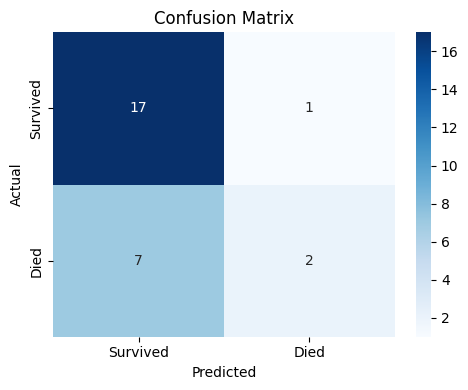


--- INTRUSION RESILIENCE RESULTS (MIMIC-III) ---
1. Clean Accuracy:
   70.37%
2. Accuracy under noise attack (noise_level=0.5):
   66.67%


In [10]:
#main pipeline
def main():
    # 1. Load Data
    df = load_and_process_data(file_path)

    # 2. Create patient-level 24h windows
    X, y = create_patient_windows(df, WINDOW_STEPS)

    # 3. Window-wise normalization (per patient sequence)
    X_norm = window_wise_normalization(X)

    print(f"Max Value in Data: {X_norm.max()}")
    print(f"Min Value in Data: {X_norm.min()}")
    print(f"Mean Value in Data: {X_norm.mean()}")

    # 4. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_norm, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
    )

    print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")

    # 5. Create DataLoaders
    train_ds = TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train).long()
    )
    test_ds = TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test).long()
    )

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # 6. Model init
    input_channels = len(FEATURE_COLUMNS)
    num_classes = 2
    window_size = WINDOW_STEPS

    model = WideScaleMIMICModel(
        input_channels=input_channels,
        num_classes=num_classes,
        window_size=window_size,
    ).to(device)

    print(
        f"Model initialized with channels={input_channels}, "
        f"window_size={window_size}"
    )

    # 7. Class weights to handle imbalance
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train,
    )
    class_weights_tensor = torch.tensor(
        class_weights, dtype=torch.float32
    ).to(device)
    print(f"Using class weights: {class_weights_tensor}")

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # 8. Train
    train_model(model, train_loader, criterion, optimizer, EPOCHS)

    # 9. Evaluate
    class_names = ["Survived", "Died"]
    evaluate_model(model, test_loader, class_names=class_names)

    # 10. Intrusion / noise resilience test
    print("\n--- INTRUSION RESILIENCE RESULTS (MIMIC-III) ---")
    print("1. Clean Accuracy:")
    print(f"   {attack_test(model, test_loader, 0.0):.2f}%")

    print("2. Accuracy under noise attack (noise_level=0.5):")
    print(f"   {attack_test(model, test_loader, 0.5):.2f}%")

if __name__ == "__main__":
    main()
